# ResNet

## Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

## Plain Networks

### Conv block

In [2]:
def conv_batch(layer, channel, kernel_size, padding='same', strides=1, activation='relu', name='0'):
    x = keras.layers.Conv2D(filters=channel,
                            kernel_size=kernel_size,
                            kernel_initializer='he_normal',
                            padding=padding,
                            strides=strides,
                            name=f'conv_{name}')(layer)
    x = keras.layers.BatchNormalization(name=f'batch_{name}')(x)
    if activation:
        x = keras.layers.Activation(activation, name=f'act_{name}')(x)
    
    return x

### Plain block 

In [3]:
def build_plain_block(input_layer, block_num=0, num_cnn=3, channel=64, is_50=True):
    x = input_layer
    
    # plain_50
    if is_50:
        for i in range(num_cnn):
            if block_num > 0 and i==0:
                x = conv_batch(x, channel, (1,1), strides=2, name=f'{block_num}_{i}1')
                x = conv_batch(x, channel, (3,3), name=f'{block_num}_{i}2')
                x = conv_batch(x, channel*4, (1,1), name=f'{block_num}_{i}3')
            else:
                x = conv_batch(x, channel, (1,1), name=f'{block_num}_{i}1')
                x = conv_batch(x, channel, (3,3), name=f'{block_num}_{i}2')
                x = conv_batch(x, channel*4, (1,1), name=f'{block_num}_{i}3')
    # plain_34
    else:
        for i in range(num_cnn):
            if block_num > 0 and i==0:
                x = conv_batch(x, channel, (3,3), strides=2, name=f'{block_num}_{i}1')
                x = conv_batch(x, channel, (3,3), name=f'{block_num}_{i}2')
            else:
                x = conv_batch(x, channel, (3,3), name=f'{block_num}_{i}1')
                x = conv_batch(x, channel, (3,3), name=f'{block_num}_{i}2')

    return x

###  Build plain network

In [36]:
 def build_plain(num_cnn_list, channel_list, is_50=True, cifar_10=False, input_shape=(32,32,3), num_classes=10, name='Plain_50'):
    
    assert len(num_cnn_list) == len(channel_list)
    
    input_layer = keras.layers.Input(shape=input_shape, name='Input')
    
    # first layer
    if cifar_10:
        plain = conv_batch(input_layer, 16, (3,3), name='first')
    else:
        conv1 = conv_batch(input_layer, 64, (7,7), strides=2, name='first')
        plain = keras.layers.MaxPool2D(pool_size=(2,2), strides=2, name='maxpool_first')(conv1)
    
    # plain block
    for block_num, (cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        plain = build_plain_block(plain, block_num, cnn, channel, is_50)
    
    gap = keras.layers.GlobalAveragePooling2D(name='GAP')(plain)
    output = keras.layers.Dense(num_classes, activation='softmax', name='FC')(gap)
    
    model = keras.Model(inputs=input_layer, outputs=output, name=name)
    
    return model


### Plain-34

In [5]:
plain_34 = build_plain(num_cnn_list=[3, 4, 6, 3],
                       channel_list=[64, 128, 256, 512],
                       is_50=False,
                       input_shape=(224,224,3),
                       name='Plain_34')
plain_34.summary()

Model: "Plain_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv_first (Conv2D)          (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_first (BatchNormalizat (None, 112, 112, 64)      256       
_________________________________________________________________
act_first (Activation)       (None, 112, 112, 64)      0         
_________________________________________________________________
maxpool_first (MaxPooling2D) (None, 56, 56, 64)        0         
_________________________________________________________________
conv_0_01 (Conv2D)           (None, 56, 56, 64)        36928     
_________________________________________________________________
batch_0_01 (BatchNormalizati (None, 56, 56, 64)        256

### Plain-50

In [6]:
plain_50 = build_plain(num_cnn_list = [3, 4, 6, 3],
                       channel_list=[64, 128, 256, 512],
                       is_50=True,
                       input_shape=(224,224,3))
plain_50.summary()

Model: "Plain_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv_first (Conv2D)          (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_first (BatchNormalizat (None, 112, 112, 64)      256       
_________________________________________________________________
act_first (Activation)       (None, 112, 112, 64)      0         
_________________________________________________________________
maxpool_first (MaxPooling2D) (None, 56, 56, 64)        0         
_________________________________________________________________
conv_0_01 (Conv2D)           (None, 56, 56, 64)        4160      
_________________________________________________________________
batch_0_01 (BatchNormalizati (None, 56, 56, 64)        256

## ResNet

### Residual block

In [7]:
def build_residual_block(input_layer, block_num=0, num_cnn=3, channel=64, is_50=True):
    x = input_layer
    
    # ResNet 50
    if is_50:
        for i in range(num_cnn):
            if i==0:
                shortcut = conv_batch(x, channel*4, (1,1), strides=2, activation=None, name=f'_shortcut_{block_num}_{i}')
                x = conv_batch(x, channel, (1,1), strides=2, name=f'{block_num}_{i}1')
                x = conv_batch(x, channel, (3,3), name=f'{block_num}_{i}2')
                x = conv_batch(x, channel*4, (1,1), activation=None, name=f'{block_num}_{i}3')
            else:
                shortcut = x
                x = conv_batch(x, channel, (1,1), name=f'{block_num}_{i}1')
                x = conv_batch(x, channel, (3,3), name=f'{block_num}_{i}2')
                x = conv_batch(x, channel*4, (1,1), activation=None, name=f'{block_num}_{i}3')
            
            x = keras.layers.Add(name=f'shortcut_add_{block_num}_{i}')([x, shortcut])
            x = keras.layers.Activation('relu', name=f'shortcut_act_{block_num}_{i}')(x)
    # ResNet 34
    else:
        for i in range(num_cnn):
            if block_num > 0 and i==0:
                shortcut = conv_batch(x, channel, (1,1), strides=2, activation=None, name=f'_shortcut_{block_num}_{i}')
                x = conv_batch(x, channel, (3,3), strides=2, name=f'{block_num}_{i}1')
                x = conv_batch(x, channel, (3,3), activation=None, name=f'{block_num}_{i}2')
            else:
                shortcut = x
                x = conv_batch(x, channel, (3,3), name=f'{block_num}_{i}1')
                x = conv_batch(x, channel, (3,3), activation=None, name=f'{block_num}_{i}2')
            
            x = keras.layers.Add(name=f'shortcut_add_{block_num}_{i}')([x, shortcut])
            x = keras.layers.Activation('relu', name=f'shortcut_act_{block_num}_{i}')(x)
    

    return x

### Build ResNet

In [8]:
def build_resnet(num_cnn_list, channel_list, is_50=True, cifar_10= False, input_shape=(32,32,3), num_classes=10, name='ResNet_50'):
    
    assert len(num_cnn_list) == len(channel_list)
    
    input_layer = keras.layers.Input(shape=input_shape, name='Input')
    
    # first layer
    if cifar_10:
        res = conv_batch(input_layer, 16, (3,3), name='first')
    else:
        conv1 = conv_batch(input_layer, 64, (7,7), strides=2, name='first')
        res = keras.layers.MaxPool2D(pool_size=(2,2), strides=2, name='maxpool_first')(conv1)
    
    # Residual block
    for block_num, (cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        res = build_residual_block(res, block_num, cnn, channel, is_50)
        
    gap = keras.layers.GlobalAveragePooling2D(name='GAP')(res)
    output = keras.layers.Dense(num_classes, activation='softmax', name='FC')(gap)
    
    model = keras.Model(inputs=input_layer, outputs=output, name=name)
    return model

### ResNet-34

In [9]:
resnet_34 = build_resnet(num_cnn_list = [3, 4, 6, 3],
                         channel_list=[64, 128, 256, 512],
                         is_50=False,
                         input_shape=(224,224,3),
                         name='ResNet_34')
resnet_34.summary()

Model: "ResNet_34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv_first (Conv2D)             (None, 112, 112, 64) 9472        Input[0][0]                      
__________________________________________________________________________________________________
batch_first (BatchNormalization (None, 112, 112, 64) 256         conv_first[0][0]                 
__________________________________________________________________________________________________
act_first (Activation)          (None, 112, 112, 64) 0           batch_first[0][0]                
__________________________________________________________________________________________

### ResNet-50

In [10]:
resnet_50 = build_resnet(num_cnn_list = [3, 4, 6, 3],
                         channel_list=[64, 128, 256, 512],
                         is_50=True,
                         input_shape=(224,224,3))
resnet_50.summary()

Model: "ResNet_50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv_first (Conv2D)             (None, 112, 112, 64) 9472        Input[0][0]                      
__________________________________________________________________________________________________
batch_first (BatchNormalization (None, 112, 112, 64) 256         conv_first[0][0]                 
__________________________________________________________________________________________________
act_first (Activation)          (None, 112, 112, 64) 0           batch_first[0][0]                
__________________________________________________________________________________________

## ResNet-20 vs ResNet-50 vs Plain-20 vs Plain-32

### Dataset (CIFAR-10)

In [11]:
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

In [12]:
print(ds_info.features)

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})


In [13]:
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(50000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)


In [14]:
def normalize_and_resize_img(image, label):
    image = tf.cast(image, tf.float32) / 255.
#     image = tf.image.resize(image, (224,224)) # resize
    return image, label

In [15]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

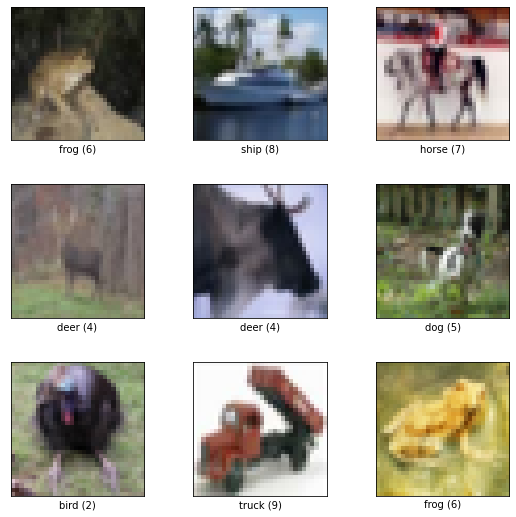

In [16]:
fig = tfds.show_examples(ds_train, ds_info)

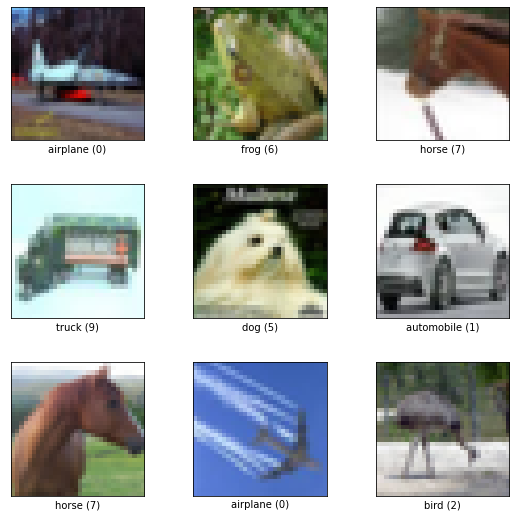

In [17]:
fig = tfds.show_examples(ds_test, ds_info)

### Train

In [18]:
BATCH_SIZE = 32 #256
iteration = 64000 #600000
EPOCH = iteration*BATCH_SIZE//int(ds_info.splits['train'].num_examples)

In [19]:
EPOCH

40

In [20]:
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [26]:
def scheduler(epoch, lr):
    if epoch == EPOCH//2:
        lr *=0.1
        print(f'learning rate : {lr}')
    elif epoch == (EPOCH//4)*3:
        lr *=0.1
        print(f'learning rate : {lr}')
    
    return lr

In [41]:
# lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=2, verbose=1)
lr_scheduler = keras.callbacks.LearningRateScheduler(scheduler)

In [28]:
resnet_20 = build_resnet(num_cnn_list = [6, 6, 6],
                         channel_list=[16, 32, 64],
                         is_50=False,
                         cifar_10=True,
                         name='ResNet_20')

resnet_20.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.1, decay=1e-4, momentum=0.9, clipnorm=1.),
    metrics=['accuracy'],
)

history_20 = resnet_20.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    callbacks=[lr_scheduler],
    use_multiprocessing=True,
)

Epoch 1/40
1562/1562 [==============================] - 31s 20ms/step - loss: 1.5352 - accuracy: 0.4372 - val_loss: 1.4604 - val_accuracy: 0.5002
Epoch 2/40
1562/1562 [==============================] - 30s 19ms/step - loss: 0.9464 - accuracy: 0.6668 - val_loss: 1.0449 - val_accuracy: 0.6445
Epoch 3/40
1562/1562 [==============================] - 30s 19ms/step - loss: 0.7193 - accuracy: 0.7504 - val_loss: 0.8337 - val_accuracy: 0.7180
Epoch 4/40
1562/1562 [==============================] - 30s 19ms/step - loss: 0.5923 - accuracy: 0.7929 - val_loss: 0.7757 - val_accuracy: 0.7489
Epoch 5/40
1562/1562 [==============================] - 30s 19ms/step - loss: 0.4973 - accuracy: 0.8257 - val_loss: 0.6521 - val_accuracy: 0.7796
Epoch 6/40
1562/1562 [==============================] - 30s 19ms/step - loss: 0.4124 - accuracy: 0.8562 - val_loss: 0.6887 - val_accuracy: 0.7757
Epoch 7/40
1562/1562 [==============================] - 30s 19ms/step - loss: 0.3492 - accuracy: 0.8793 - val_loss: 0.6006 -

In [29]:
resnet_32 = build_resnet(num_cnn_list = [10, 10, 10],
                         channel_list=[16, 32, 64],
                         is_50=False,
                         cifar_10=True,
                         name='ResNet_32')

resnet_32.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.1, decay=1e-4, momentum=0.9, clipnorm=1.),
    metrics=['accuracy'],
)

history_32 = resnet_32.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    callbacks=[lr_scheduler],
    use_multiprocessing=True,
)

Epoch 1/40
1562/1562 [==============================] - 47s 30ms/step - loss: 1.8435 - accuracy: 0.3116 - val_loss: 1.6738 - val_accuracy: 0.4054
Epoch 2/40
1562/1562 [==============================] - 46s 29ms/step - loss: 1.2619 - accuracy: 0.5438 - val_loss: 1.2664 - val_accuracy: 0.5504
Epoch 3/40
1562/1562 [==============================] - 47s 30ms/step - loss: 0.9270 - accuracy: 0.6699 - val_loss: 0.9171 - val_accuracy: 0.6822
Epoch 4/40
1562/1562 [==============================] - 48s 30ms/step - loss: 0.7288 - accuracy: 0.7448 - val_loss: 0.7584 - val_accuracy: 0.7347
Epoch 5/40
1562/1562 [==============================] - 47s 30ms/step - loss: 0.5992 - accuracy: 0.7942 - val_loss: 0.6828 - val_accuracy: 0.7657
Epoch 6/40
1562/1562 [==============================] - 47s 30ms/step - loss: 0.5074 - accuracy: 0.8230 - val_loss: 0.7597 - val_accuracy: 0.7514
Epoch 7/40
1562/1562 [==============================] - 47s 30ms/step - loss: 0.4255 - accuracy: 0.8528 - val_loss: 0.7215 -

In [37]:
plain_20 = build_plain(num_cnn_list=[6, 6, 6],
                       channel_list=[16, 32, 64],
                       is_50=False,
                       cifar_10=True,
                       name='Plain_20')

plain_20.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.1, decay=1e-4, momentum=0.9, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain_20 = plain_20.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    callbacks=[lr_scheduler],
    use_multiprocessing=True,
)

Epoch 1/40
1562/1562 [==============================] - 29s 19ms/step - loss: 1.9884 - accuracy: 0.2536 - val_loss: 2.1262 - val_accuracy: 0.2540
Epoch 2/40
1562/1562 [==============================] - 28s 18ms/step - loss: 1.7030 - accuracy: 0.3679 - val_loss: 1.8334 - val_accuracy: 0.3359
Epoch 3/40
1562/1562 [==============================] - 29s 18ms/step - loss: 1.5278 - accuracy: 0.4343 - val_loss: 1.5599 - val_accuracy: 0.4428
Epoch 4/40
1562/1562 [==============================] - 29s 18ms/step - loss: 1.3600 - accuracy: 0.5044 - val_loss: 1.4786 - val_accuracy: 0.4895
Epoch 5/40
1562/1562 [==============================] - 29s 18ms/step - loss: 1.2042 - accuracy: 0.5684 - val_loss: 1.2525 - val_accuracy: 0.5630
Epoch 6/40
1562/1562 [==============================] - 29s 18ms/step - loss: 1.0776 - accuracy: 0.6179 - val_loss: 1.1452 - val_accuracy: 0.5883
Epoch 7/40
1562/1562 [==============================] - 29s 18ms/step - loss: 0.9684 - accuracy: 0.6586 - val_loss: 1.0009 -

In [38]:
plain_32 = build_plain(num_cnn_list=[10, 10, 10],
                       channel_list=[16, 32, 64],
                       is_50=False,
                       cifar_10=True,
                       name='Plain_32')

plain_32.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.1, decay=1e-4, momentum=0.9, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain_32 = plain_32.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    callbacks=[lr_scheduler],
    use_multiprocessing=True,
)

Epoch 1/40
1562/1562 [==============================] - 45s 29ms/step - loss: 2.1010 - accuracy: 0.1870 - val_loss: 2.9581 - val_accuracy: 0.1943
Epoch 2/40
1562/1562 [==============================] - 45s 29ms/step - loss: 1.8866 - accuracy: 0.2801 - val_loss: 2.0910 - val_accuracy: 0.2706
Epoch 3/40
1562/1562 [==============================] - 45s 29ms/step - loss: 1.7650 - accuracy: 0.3425 - val_loss: 2.4383 - val_accuracy: 0.2732
Epoch 4/40
1562/1562 [==============================] - 45s 29ms/step - loss: 1.6308 - accuracy: 0.3974 - val_loss: 1.8252 - val_accuracy: 0.3897
Epoch 5/40
1562/1562 [==============================] - 45s 29ms/step - loss: 1.5233 - accuracy: 0.4397 - val_loss: 1.4705 - val_accuracy: 0.4563
Epoch 6/40
1562/1562 [==============================] - 45s 29ms/step - loss: 1.4410 - accuracy: 0.4741 - val_loss: 1.5390 - val_accuracy: 0.4534
Epoch 7/40
1562/1562 [==============================] - 45s 29ms/step - loss: 1.3774 - accuracy: 0.4978 - val_loss: 1.5476 -

### Comparison

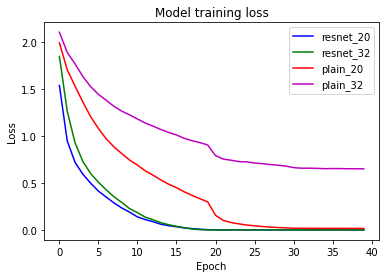

In [39]:
plt.plot(history_20.history['loss'], 'b')
plt.plot(history_32.history['loss'], 'g')
plt.plot(history_plain_20.history['loss'], 'r')
plt.plot(history_plain_32.history['loss'], 'm')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_20', 'resnet_32', 'plain_20', 'plain_32'], loc='upper right')
plt.show()

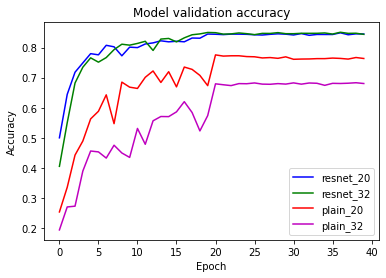

In [40]:
plt.plot(history_20.history['val_accuracy'], 'b')
plt.plot(history_32.history['val_accuracy'], 'g')
plt.plot(history_plain_20.history['val_accuracy'], 'r')
plt.plot(history_plain_32.history['val_accuracy'], 'm')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_20', 'resnet_32', 'plain_20', 'plain_32'], loc='lower right')
plt.show()